Step 1: Preparing Fashion-MNIST dataset...
Loading Fashion-MNIST dataset...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Saving training images...
Processed 500 train images
Processed 1000 train images
Processed 1500 train images
Processed 2000 train images
Processed 2500 train images
Processed 3000 train images
Processed 3500 train images
Processed 4000 train images
Processed 4500 train images
Processed 5000 train images
Saving test images...
Processed 500 test images
Processed 1000 test images
Dataset prepared and saved to /content/fashion_mnist_images

Step 2: Training the model and generating visualizations...
Building model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loading Fashion-MNIST dataset for training...
Preprocessing traini

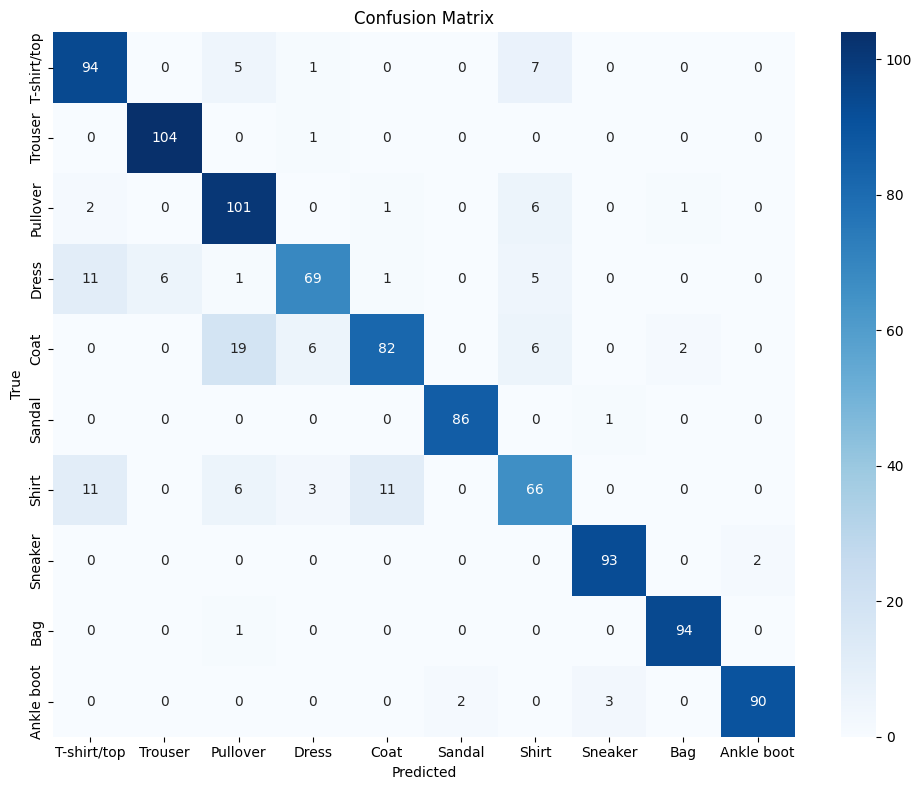

Generating accuracy and loss graphs...


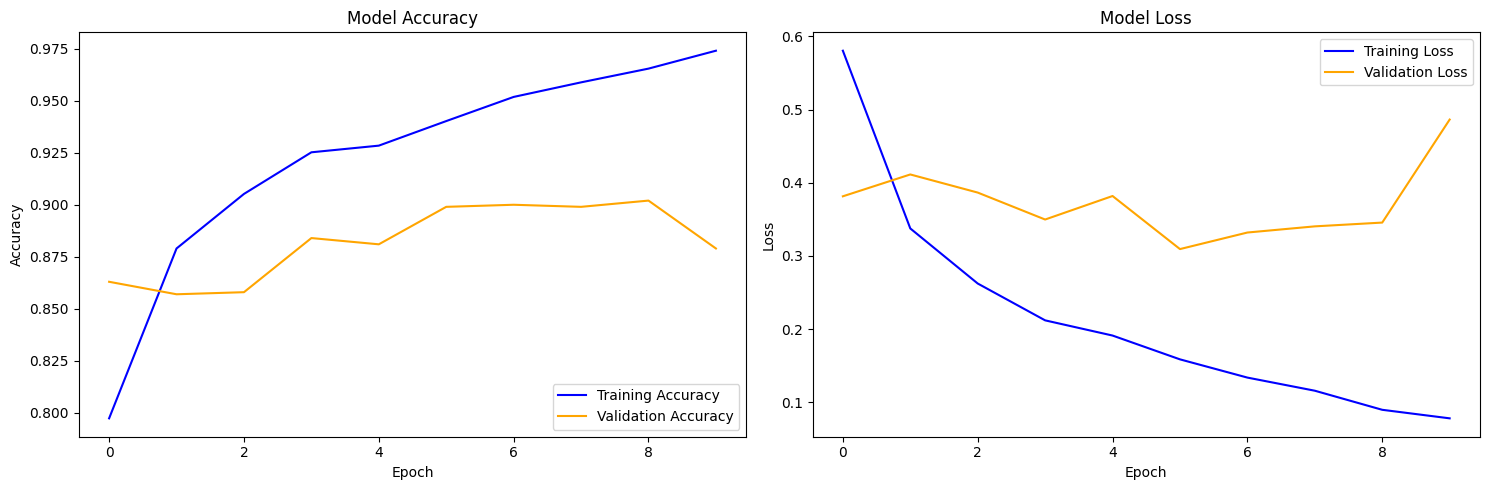

Generating ROC curve...


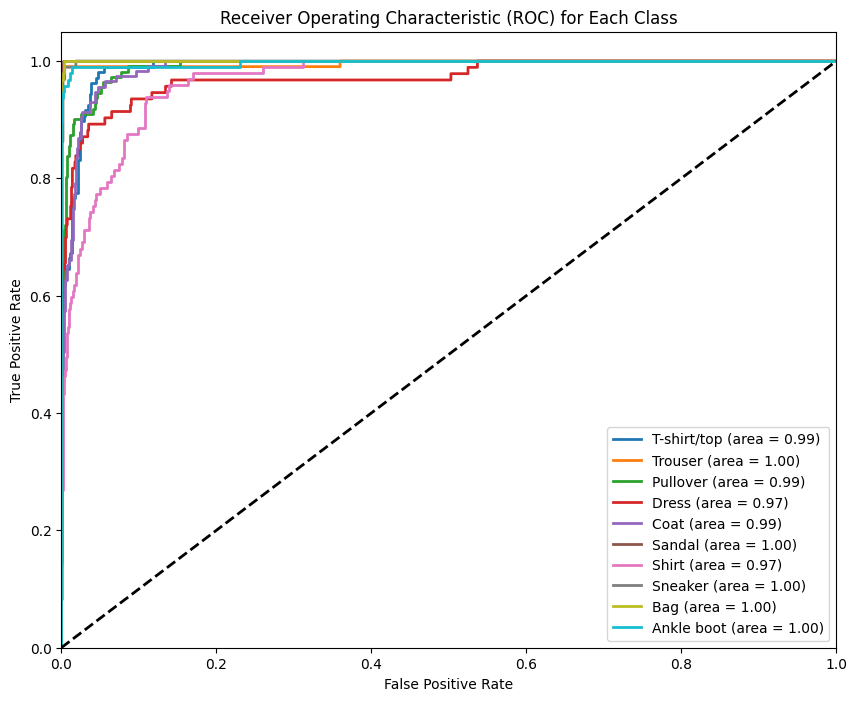

Generating precision, recall, and F1 score graphs...


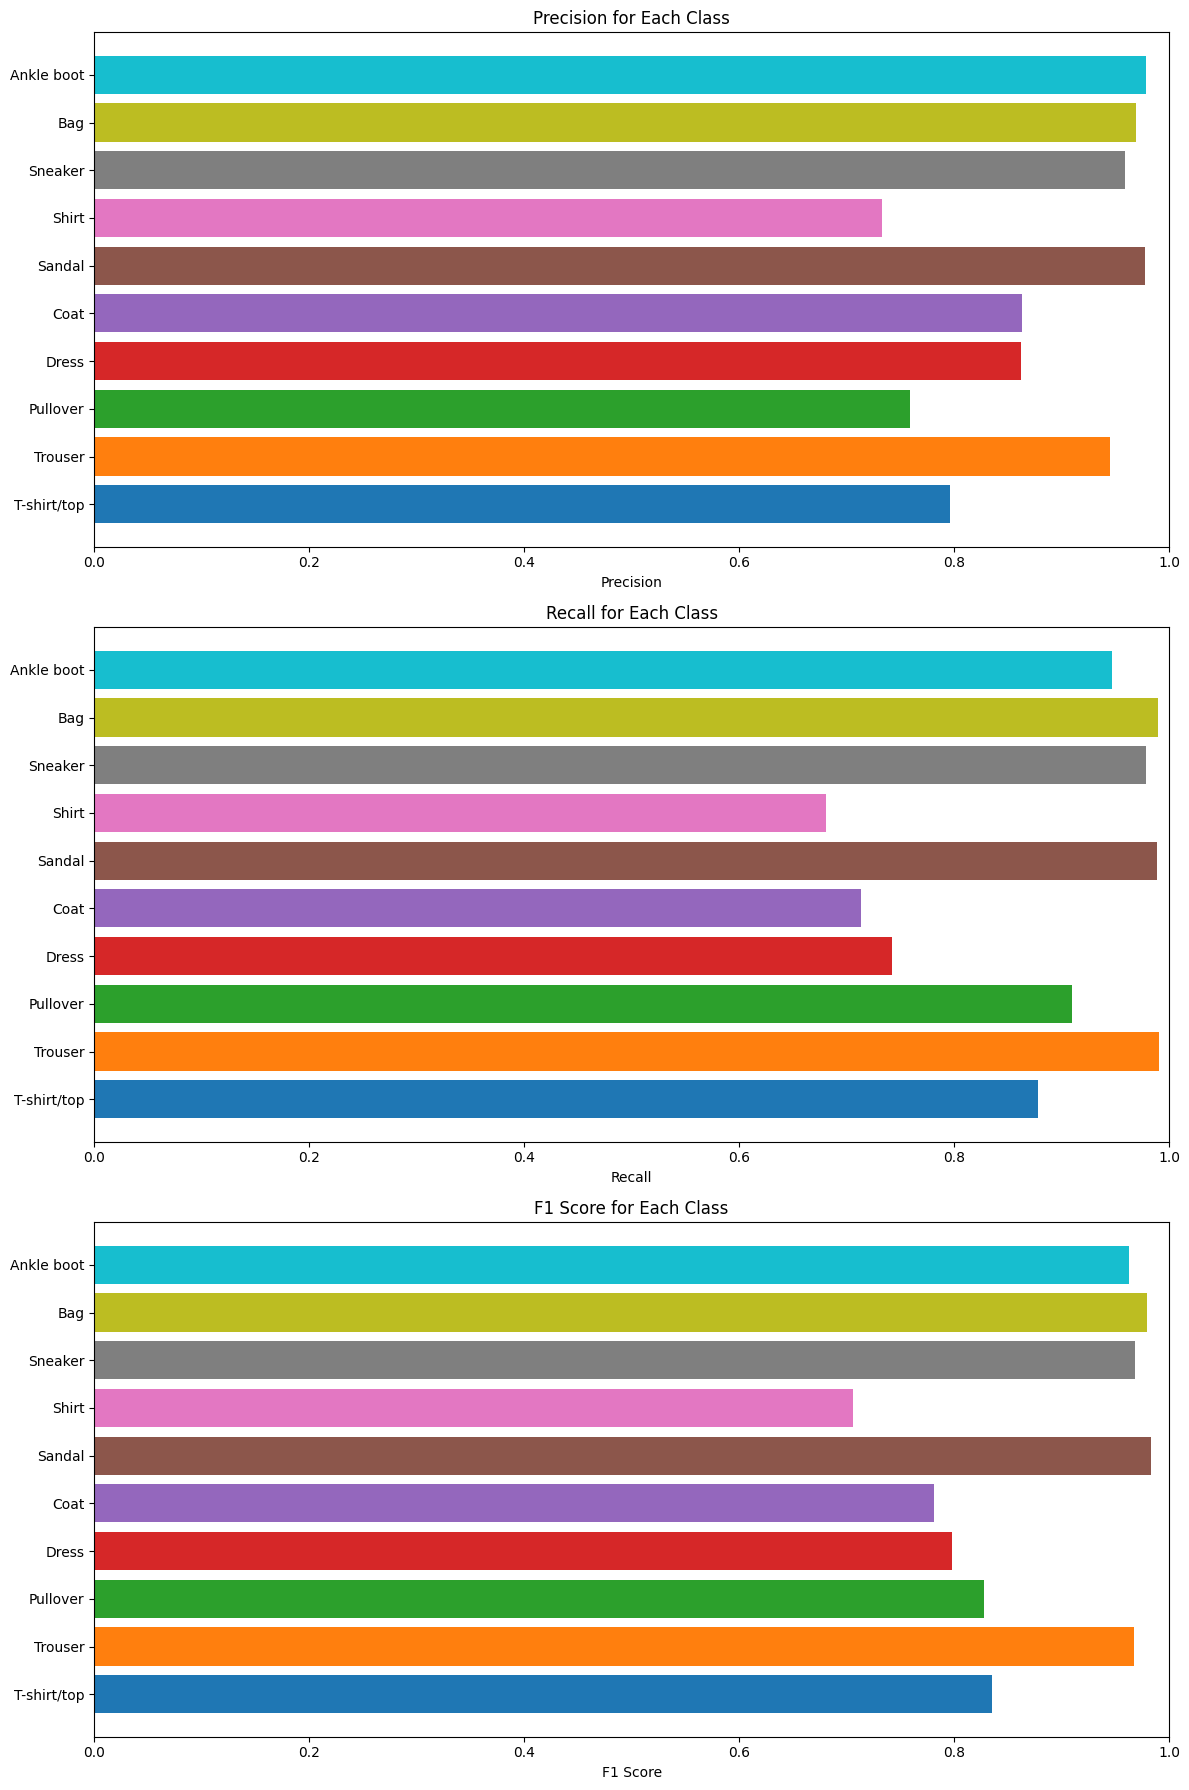


Step 3: Extracting features...
Extracting features for all products...
Processed features for 80/6000 products
Processed features for 160/6000 products
Processed features for 240/6000 products
Processed features for 320/6000 products
Processed features for 400/6000 products
Processed features for 480/6000 products
Processed features for 560/6000 products
Processed features for 640/6000 products
Processed features for 720/6000 products
Processed features for 800/6000 products
Processed features for 880/6000 products
Processed features for 960/6000 products
Processed features for 1040/6000 products
Processed features for 1120/6000 products
Processed features for 1200/6000 products
Processed features for 1280/6000 products
Processed features for 1360/6000 products
Processed features for 1440/6000 products
Processed features for 1520/6000 products
Processed features for 1600/6000 products
Processed features for 1680/6000 products
Processed features for 1760/6000 products
Processed feature

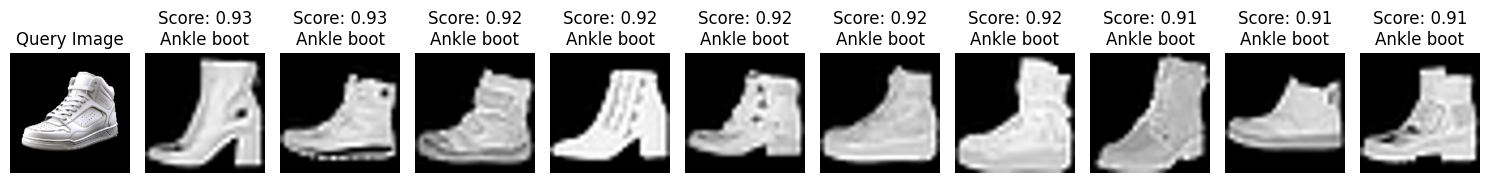

In [1]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import VGG16, EfficientNetB0, MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Concatenate, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import gc

class FashionCBIR:
    def __init__(self, base_dir, image_size=(224, 224)):
        self.image_size = image_size
        self.base_dir = base_dir
        self.product_database = []
        self.feature_database = None
        self.history = None
        self.model = None
        self.classifier = None
        self.label_names = [
            "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
        ]
        
        # Set memory growth for GPU
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
            except RuntimeError as e:
                print(e)

    def _build_model(self):
        # Define inputs - using smaller image size to reduce memory usage
        input_shape = (self.image_size[0], self.image_size[1], 3)
        input_tensor = Input(shape=input_shape)
        
        # Load pre-trained models with shared input tensor to save memory
        vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=input_tensor)
        efficientnet = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=input_tensor)
        mobilenet = MobileNetV3Small(weights="imagenet", include_top=False, input_tensor=input_tensor)

        # Freeze layers (no training needed)
        vgg16.trainable = False
        efficientnet.trainable = False
        mobilenet.trainable = False

        # Extract features from all models
        vgg_output = GlobalAveragePooling2D()(vgg16.output)
        efficient_output = GlobalAveragePooling2D()(efficientnet.output)
        mobile_output = GlobalAveragePooling2D()(mobilenet.output)

        # Concatenate features
        merged_features = Concatenate()([vgg_output, efficient_output, mobile_output])

        # Fully connected layers for feature refinement
        dense_1 = Dense(512, activation='relu')(merged_features)
        features = Dense(256, activation='relu')(dense_1)
        
        # Create the feature extractor model
        self.model = Model(inputs=input_tensor, outputs=features)
        
        # Classification layer
        predictions = Dense(10, activation='softmax')(features)
        
        # Full classification model
        self.classifier = Model(inputs=input_tensor, outputs=predictions)
        self.classifier.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Clear backend session to free memory
        gc.collect()

    def prepare_fashion_mnist(self):
        """Load and prepare Fashion-MNIST dataset"""
        print("Loading Fashion-MNIST dataset...")
        (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
        
        # Create directories for each category
        for label in self.label_names:
            category_dir = os.path.join(self.base_dir, label.replace("/", "-"))
            os.makedirs(category_dir, exist_ok=True)

        print("Saving training images...")
        self._save_dataset_images(train_images, train_labels, "train", max_samples=5000)  # Limit samples to save memory
        
        print("Saving test images...")
        self._save_dataset_images(test_images, test_labels, "test", max_samples=1000)  # Limit samples to save memory
        
        print(f"Dataset prepared and saved to {self.base_dir}")
        
        return (train_images[:5000], train_labels[:5000]), (test_images[:1000], test_labels[:1000])

    def _save_dataset_images(self, images, labels, prefix, max_samples=None):
        """Helper function to save dataset images with sample limit for memory efficiency"""
        if max_samples:
            images = images[:max_samples]
            labels = labels[:max_samples]
            
        for i, (image, label) in enumerate(zip(images, labels)):
            img = Image.fromarray(image).convert('RGB')
            img = img.resize(self.image_size)
            
            category = self.label_names[label].replace("/", "-")
            filename = f'{prefix}_image_{i+1}.png'
            save_path = os.path.join(self.base_dir, category, filename)
            img.save(save_path)
            
            product_info = {
                'image_path': save_path,
                'category': category,
                'product_id': f'{prefix}_{i+1}',
                'label_index': label
            }
            self.product_database.append(product_info)
            
            if (i + 1) % 500 == 0:
                print(f"Processed {i + 1} {prefix} images")
                gc.collect()  # Free memory periodically

    def preprocess_image(self, image_path):
        """Preprocess single image for feature extraction"""
        img = load_img(image_path, target_size=self.image_size)
        img_array = img_to_array(img)
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
        return np.expand_dims(img_array, axis=0)

    def preprocess_batch(self, images, batch_size=32):
        """Preprocess batch of images for training with batching to save memory"""
        total = len(images)
        processed_batches = []
        
        for start_idx in range(0, total, batch_size):
            end_idx = min(start_idx + batch_size, total)
            batch_images = images[start_idx:end_idx]
            
            # Resize and convert to RGB
            batch_processed = np.zeros((len(batch_images), self.image_size[0], self.image_size[1], 3), dtype=np.float32)
            
            for i, img in enumerate(batch_images):
                # Convert to RGB and resize
                pil_img = Image.fromarray(img).convert('RGB')
                pil_img = pil_img.resize(self.image_size)
                img_array = img_to_array(pil_img)
                batch_processed[i] = img_array
            
            # Apply preprocessing
            batch_processed = tf.keras.applications.vgg16.preprocess_input(batch_processed)
            processed_batches.append(batch_processed)
            
            # Free memory
            if (end_idx % (batch_size * 10)) == 0:
                print(f"Processed {end_idx}/{total} images")
                gc.collect()
        
        # Combine all batches
        return np.vstack(processed_batches)

    def train_model(self, epochs=10, batch_size=16):
        """Train the classification model with smaller batch size"""
        # Build model first
        print("Building model...")
        self._build_model()
        
        print("Loading Fashion-MNIST dataset for training...")
        (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
        
        # Use smaller subset for training to avoid memory issues
        train_size = min(5000, len(train_images))
        test_size = min(1000, len(test_images))
        
        train_images = train_images[:train_size]
        train_labels = train_labels[:train_size]
        test_images = test_images[:test_size]
        test_labels = test_labels[:test_size]
        
        # Preprocess images in smaller batches
        print("Preprocessing training data...")
        train_data = self.preprocess_batch(train_images, batch_size=batch_size)
        test_data = self.preprocess_batch(test_images, batch_size=batch_size)
        
        # Convert labels to categorical
        train_labels_cat = to_categorical(train_labels, 10)
        test_labels_cat = to_categorical(test_labels, 10)
        
        # Train the model with smaller batch size
        print(f"Training model for {epochs} epochs...")
        self.history = self.classifier.fit(
            train_data, train_labels_cat,
            epochs=epochs,
            batch_size=batch_size,  # Smaller batch size
            validation_data=(test_data, test_labels_cat),
            verbose=1
        )
        
        # Evaluate the model
        print("Evaluating model...")
        loss, accuracy = self.classifier.evaluate(test_data, test_labels_cat)
        print(f"Test accuracy: {accuracy:.4f}")
        
        # Generate predictions for metrics
        y_pred_prob = self.classifier.predict(test_data, batch_size=batch_size)
        y_pred = np.argmax(y_pred_prob, axis=1)
        
        # Generate and plot metrics
        self.plot_confusion_matrix(test_labels, y_pred)
        self.plot_accuracy_loss()
        self.plot_roc_curve(test_labels, y_pred_prob)
        self.plot_precision_recall_f1(test_labels, y_pred)
        
        # Clear memory
        gc.collect()
        return (train_data, train_labels), (test_data, test_labels)

    def extract_features(self, batch_size=16):
        """Extract features in batches to save memory"""
        if self.model is None:
            print("Model not built yet. Building model...")
            self._build_model()
            
        print("Extracting features for all products...")
        features = []
        total_products = len(self.product_database)
        
        # Process in batches
        for i in range(0, total_products, batch_size):
            batch_end = min(i + batch_size, total_products)
            batch_products = self.product_database[i:batch_end]
            batch_images = []
            
            # Preprocess batch
            for product in batch_products:
                img_processed = self.preprocess_image(product['image_path'])[0]  # Remove batch dimension
                batch_images.append(img_processed)
            
            # Stack images into a batch
            batch_array = np.array(batch_images)
            
            # Extract features
            batch_features = self.model.predict(batch_array, verbose=0)
            
            # Store features
            for feature in batch_features:
                features.append(feature.flatten())
            
            # Log progress and free memory
            if (batch_end % (batch_size * 5)) == 0 or batch_end == total_products:
                print(f"Processed features for {batch_end}/{total_products} products")
                gc.collect()
        
        self.feature_database = np.array(features)
        print("Feature extraction completed")

    def find_similar_products(self, query_image_path, num_results=10):
        """Find similar products for a given query image"""
        if self.model is None:
            print("Model not built yet. Building model...")
            self._build_model()
            
        query_processed = self.preprocess_image(query_image_path)
        query_features = self.model.predict(query_processed, verbose=0).flatten()
        
        similarities = cosine_similarity([query_features], self.feature_database)
        similar_indices = np.argsort(similarities[0])[::-1][:num_results]
        
        similar_products = []
        for idx in similar_indices:
            product = self.product_database[idx].copy()
            product['similarity_score'] = similarities[0][idx]
            similar_products.append(product)
        
        return similar_products

    def display_results(self, query_image_path, similar_products):
        """Display query image and similar products"""
        num_results = len(similar_products)
        plt.figure(figsize=(15, 3 + num_results // 5))
        
        # Display query image
        plt.subplot(1, num_results + 1, 1)
        query_img = load_img(query_image_path, target_size=self.image_size)
        plt.imshow(query_img)
        plt.title('Query Image')
        plt.axis('off')
        
        # Display similar products
        for i, product in enumerate(similar_products):
            plt.subplot(1, num_results + 1, i + 2)
            img = load_img(product['image_path'], target_size=self.image_size)
            plt.imshow(img)
            plt.title(f"Score: {product['similarity_score']:.2f}\n{product['category']}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    #----- Visualization Methods -----#
    
    def plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix"""
        print("Generating confusion matrix...")
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_names, 
                   yticklabels=self.label_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()
        
    def plot_accuracy_loss(self):
        """Plot training and validation accuracy and loss"""
        if self.history is None:
            print("No training history available. Run train_model() first.")
            return
            
        print("Generating accuracy and loss graphs...")
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot accuracy
        ax1.plot(self.history.history['accuracy'], '-', color='blue', label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], '-', color='orange', label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend(loc='lower right')
        ax1.grid(False)
        
        # Plot loss
        ax2.plot(self.history.history['loss'], '-', color='blue', label='Training Loss')
        ax2.plot(self.history.history['val_loss'], '-', color='orange', label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend(loc='upper right')
        ax2.grid(False)
        
        plt.tight_layout()
        plt.show()
        
    def plot_roc_curve(self, y_test, y_score):
        """Plot ROC curve for each class"""
        print("Generating ROC curve...")
        # Compute ROC curve and ROC area for each class
        n_classes = len(self.label_names)
        y_test_bin = to_categorical(y_test, n_classes)
        
        # Plot all ROC curves
        plt.figure(figsize=(10, 8))
        
        colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
        
        for i, color in zip(range(n_classes), colors):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=color, lw=2,
                     label=f'{self.label_names[i]} (area = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) for Each Class')
        plt.legend(loc="lower right")
        plt.show()
        
    def plot_precision_recall_f1(self, y_true, y_pred):
        """Plot precision, recall and f1 score for each class"""
        print("Generating precision, recall, and F1 score graphs...")
        
        # Calculate metrics
        precision = precision_score(y_true, y_pred, average=None)
        recall = recall_score(y_true, y_pred, average=None)
        f1 = f1_score(y_true, y_pred, average=None)
        
        # Generate colors for each class
        n_classes = len(self.label_names)
        colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
        
        # Create subplots
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
        
        # Precision plot
        ax1.barh(self.label_names, precision, color=colors)
        ax1.set_title('Precision for Each Class')
        ax1.set_xlabel('Precision')
        ax1.set_xlim(0, 1)
        
        # Recall plot
        ax2.barh(self.label_names, recall, color=colors)
        ax2.set_title('Recall for Each Class')
        ax2.set_xlabel('Recall')
        ax2.set_xlim(0, 1)
        
        # F1 score plot
        ax3.barh(self.label_names, f1, color=colors)
        ax3.set_title('F1 Score for Each Class')
        ax3.set_xlabel('F1 Score')
        ax3.set_xlim(0, 1)
        
        plt.tight_layout()
        plt.show()

def main():
    base_dir = '/content/fashion_mnist_images'  # Change this path as needed
    
    # Initialize CBIR system
    cbir = FashionCBIR(base_dir=base_dir, image_size=(224, 224))
    
    # Prepare Fashion-MNIST dataset (only needed once)
    print("Step 1: Preparing Fashion-MNIST dataset...")
    cbir.prepare_fashion_mnist()
    
    # Train the model (this also generates all visualization metrics)
    print("\nStep 2: Training the model and generating visualizations...")
    cbir.train_model(epochs=10, batch_size=16)  # Reduced batch size
    
    # Extract features for all products
    print("\nStep 3: Extracting features...")
    cbir.extract_features(batch_size=16)  # Process in smaller batches
    
    # Example: Find similar products for a query image
    query_image_path = '/kaggle/input/sneaker/sneaker.png'  # Change this path to your query image
    similar_products = cbir.find_similar_products(query_image_path, num_results=10)

    # Display results
    cbir.display_results(query_image_path, similar_products)

if __name__ == "__main__":
    main()